# Assigment 1
## POS Tagging
### Giorgia Castelli, Alice Fratini, Madalina Mone

The aim of this notebook is to address the task of POS tagging, a classification problem that uses Neural Networks to recognize different part of speech. In this case we will implement three different models for neural POS tagger. The baseline model implement a Bidirectional LSTM with a dense layer on top, the first model add an additional LSTM layer to the baseline, meanwhile the second add an additional Dense layer to the baseline.
The embedding layer of every model will be based on Glove.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import urllib.request
import zipfile

# typing
from typing import List, Callable, Dict

# Task 1 - Corpus

Here we download the Dataset and split it into Train, Val and Test.

In [ ]:
#download zip from url
def download_url(download_path: Path, url: str):
    urllib.request.urlretrieve(url, filename=download_path)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset")
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")


In [ ]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)

Current work directory: c:\Users\giorg\Documents\AI23\NLP\Assignment1


We decided to split the dataset using strong punctation marks as `. , ! , ? , \n` in order to have shorter sentences than the real dataset. <br>
We keep track of the sentence `id` to correctly divide the dataset into Train, Val and Test. <br>
While we use `sentence` column to define the costruction of single sentences, which will be passed to the encoding.

In [ ]:
#create method to encode dataset into pd.DataFrame
df_rows = []
dataset_folder= dataset_folder.joinpath(dataset_name)
def encode_dataset(dataset_folder: Path):
    count=0
    for file_path in dataset_folder.glob("*.dp"):
        with file_path.open(mode="r", encoding="utf-8") as dp_file:
            dp = dp_file.read()
            id = file_path.stem.split("_")[1]
            file_name =int(id)
            dp = dp.split("\n")
            for el in dp:
                if el != "":
                    word= el.split("\t")[0]
                    pos= el.split("\t")[1]
                    #we don't need the third column but we have to split it to avoid errors
                    n = el.split("\t")[2]

                    df_row = {
                        "word": word,
                        "pos": pos,
                        "sentence": count,
                        "id": file_name
                    }
                    if word in [".", "\n", "!", "?"]:
                        count += 1
                    df_rows.append(df_row)

encode_dataset(dataset_folder)



In [ ]:
folder = Path.cwd().joinpath("Datasets", "Dataframes", dataset_name)
if not folder.exists():
    folder.mkdir(parents=True)

In [ ]:
#divide df into sentences and pos
df = pd.DataFrame(df_rows, columns=['word', 'pos', 'sentence','id'])
df.head()


,word,pos,sentence,id
0,Pierre,NNP,0,1
1,Vinken,NNP,0,1
2,",",",",0,1
3,61,CD,0,1
4,years,NNS,0,1


After the DataSet is splitted we create each sentence grouping by the column described above.

In [ ]:
#split the dataset into train, validation and test
#train contains the words that have value of sentence lower than 100,
# validation the next 50 and test the rest
#train_df if sentence < 100
train_interval = (0, 100)  # Sentences 0 to 99
val_interval = (100, 150) # Sentences 100 to 149
test_interval = (150, 200) # Sentences 150 to 199

# Split DataFrame
train_df = df[(df['id'] >= train_interval[0]) & (df['id'] < train_interval[1])]
val_df = df[(df['id'] >= val_interval[0]) & (df['id'] < val_interval[1])]
test_df = df[(df['id'] >= test_interval[0]) & (df['id'] < test_interval[1])]


X_train_raw = train_df.groupby('sentence').word.apply(list).reset_index()['word']
X_val_raw = val_df.groupby('sentence').word.apply(list).reset_index()['word']
X_test_raw = test_df.groupby('sentence').word.apply(list).reset_index()['word']

y_train_raw = train_df.groupby('sentence').pos.apply(list).reset_index()['pos']
y_val_raw = val_df.groupby('sentence').pos.apply(list).reset_index()['pos']
y_test_raw = test_df.groupby('sentence').pos.apply(list).reset_index()['pos']


# type of X_train_raw
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
#print last element of train_df
print(X_train_raw)


(46451, 4)
(31924, 4)
(15709, 4)
0       [Pierre, Vinken, ,, 61, years, old, ,, will, j...
1       [Mr., Vinken, is, chairman, of, Elsevier, N.V....
2       [Rudolph, Agnew, ,, 55, years, old, and, forme...
3       [A, form, of, asbestos, once, used, to, make, ...
4       [The, asbestos, fiber, ,, crocidolite, ,, is, ...
                              ...                        
1912    [The, U.S., Chamber, of, Commerce, ,, still, o...
1913    [Zenith, Data, Systems, Corp., ,, a, subsidiar...
1914    [Rockwell, International, Corp., won, a, $, 13...
1915    [Martin, Marietta, Corp., was, given, a, $, 29...
1916    [Federal, Data, Corp., got, a, $, 29.4, millio...
Name: word, Length: 1917, dtype: object


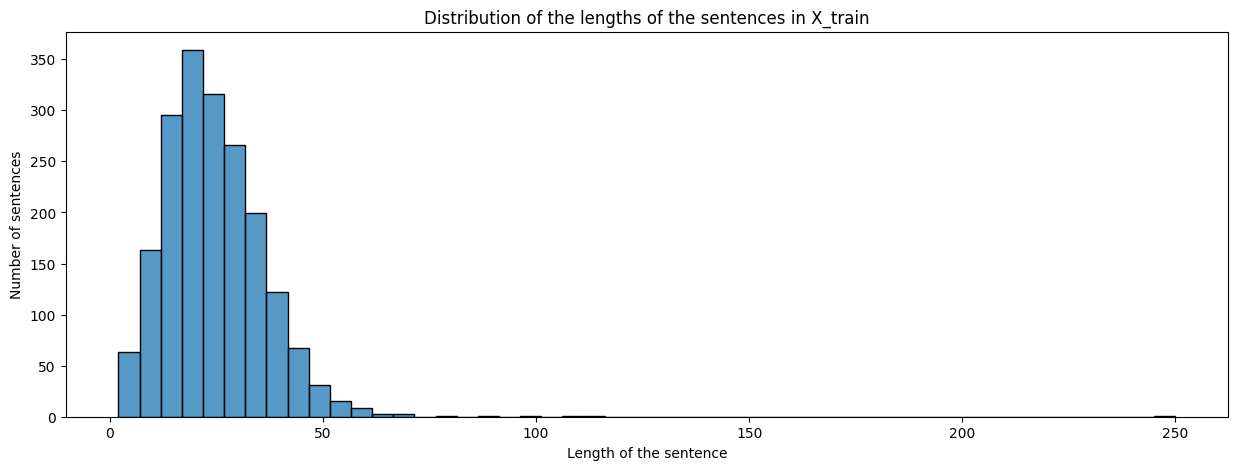

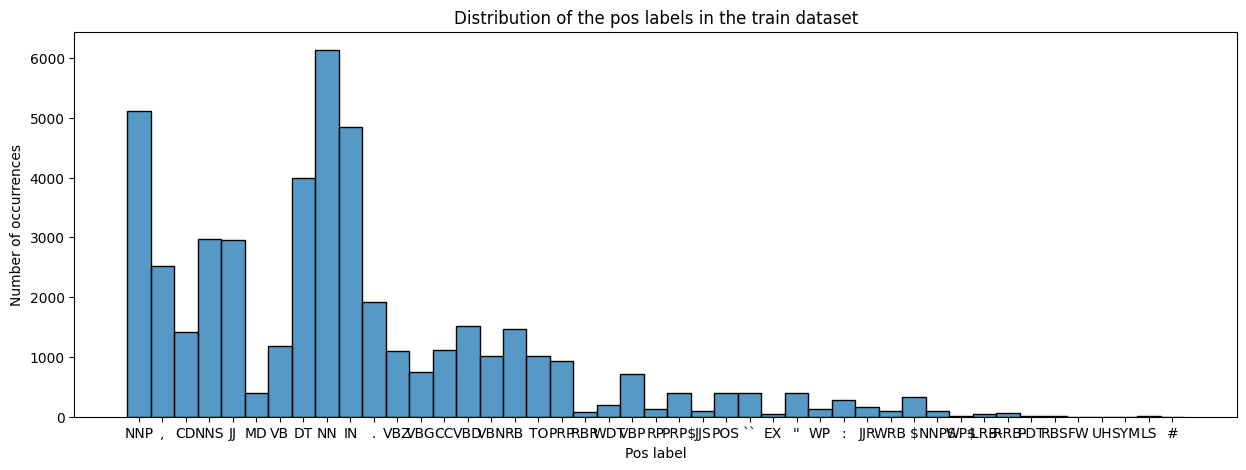

In [ ]:
#plot the distribution of the lengths of the sentences
plt.figure(figsize=(15, 5))
sns.histplot([len(sentence) for sentence in X_train_raw], bins=50)
plt.title("Distribution of the lengths of the sentences in X_train")
plt.xlabel("Length of the sentence")
plt.ylabel("Number of sentences")
plt.show()

#plot the distribution of the pos labels in the train dataset
plt.figure(figsize=(15, 5))
sns.histplot(train_df['pos'])
plt.title("Distribution of the pos labels in the train dataset")
plt.xlabel("Pos label")
plt.ylabel("Number of occurrences")
plt.show()


In this plot we can see the distribution of the length of the sentences, we can observe that the majority of the sentences have a lenth between 20-25 words. And only fews sentences have more than 60 words.

The other plot shows the distribution of the POS labels in the training set, showing that the two most common POS are NNP and NN

# Text Encoding

In this section we start the encoding process using GloVe dictionary with an embedding dimesion = 50. During the process we tried other dimensions but this one works better in quality of time and precision.

In [ ]:
import gensim
import gensim.downloader as gloader

EMB_DIM = 50
embedding_model = gloader.load(f'glove-wiki-gigaword-{EMB_DIM}')

#print the number of words in the model


In [ ]:
print(f"Number of words in the model: {len(embedding_model.index_to_key)}")


Number of words in the model: 400000


## Vocabulary class

In this section, we create the vocabulary using `keras Tokenizer` based on the train dataset, we also mark the OOV Tokens as `<UNK>` so we can handle them during the embedding phase. <br>
Then we encode the tokens using the upmentioned vocabulary

In [ ]:
#create vocabulary using keras tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from typing import List

def create_vocabulary(sentences: List[List[str]]) -> Tokenizer:
    tokenizer = Tokenizer(filters="",oov_token="<UNK>")
    tokenizer.fit_on_texts(sentences)
    return tokenizer

train_tokenizer = create_vocabulary(X_train_raw)
print(f"Number of words in the vocabulary: {len(train_tokenizer.word_index)}")
#pritn the first 10 words in the vocabulary
#print(list(train_tokenizer.word_index.items())[:10])
pos_tokenizer = create_vocabulary(y_train_raw)
print(f"Number of pos in the vocabulary: {len(pos_tokenizer.word_index)}")


#encode the sentences
def encode_sentences(tokenizer: Tokenizer, sentences: List[List[str]]) -> np.ndarray:
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    return encoded_sentences

X_train = encode_sentences(train_tokenizer, X_train_raw)
X_val = encode_sentences(train_tokenizer, X_val_raw)
X_test = encode_sentences(train_tokenizer, X_test_raw)

y_train = encode_sentences(pos_tokenizer, y_train_raw)
y_val = encode_sentences(pos_tokenizer, y_val_raw)
y_test = encode_sentences(pos_tokenizer, y_test_raw)

#print the first sentence

print(X_train[0])
print(y_train[0])





Number of words in the vocabulary: 7305
[('<UNK>', 1), (',', 2), ('the', 3), ('.', 4), ('of', 5), ('to', 6), ('a', 7), ('in', 8), ('and', 9), ('for', 10)]
Number of pos in the vocabulary: 46
[3389, 2282, 2, 1723, 65, 372, 2, 40, 1346, 3, 190, 24, 7, 1106, 261, 694, 2283, 4]
[3, 3, 8, 12, 6, 7, 8, 21, 13, 5, 2, 4, 5, 7, 2, 3, 12, 9]


In this section, we apply the padding process so each token has the same length. We choose this value due to the analysis on the length of the sentences we did before.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the sequences
MAX_SEQ_LENGTH = 64 #128 o 256

X_train_pad = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, padding='post')
y_train_pad = pad_sequences(y_train, maxlen=MAX_SEQ_LENGTH, padding='post')

X_val_pad = pad_sequences(X_val, maxlen=MAX_SEQ_LENGTH, padding='post')
y_val_pad = pad_sequences(y_val, maxlen=MAX_SEQ_LENGTH, padding='post')

X_test_pad = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, padding='post')
y_test_pad = pad_sequences(y_test, maxlen=MAX_SEQ_LENGTH, padding='post')

print(f"X_train_pad: {X_train_pad.shape}")
print(f"y_train_pad: {y_train_pad.shape}")

print(f"X_val_pad: {X_val_pad.shape}")
print(f"y_val_pad: {y_val_pad.shape}")

print(f"X_test_pad: {X_test_pad.shape}")
print(f"y_test_pad: {y_test_pad.shape}")




X_train_pad: (1917, 64)
y_train_pad: (1917, 64)
X_val_pad: (1310, 64)
y_val_pad: (1310, 64)
X_test_pad: (647, 64)
y_test_pad: (647, 64)


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, train_tokenizer.word_index.keys())
oov_percentage = float(len(oov_terms)) * 100 / len(train_tokenizer.word_index)
print(f"Total terms in the dataset: {oov_terms[0:10]}")
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total terms in the dataset: ['crocidolite', '236.74', 'rate-sensitive', 'times-stock', 'custom-chip', 'weisfield', 'fetal-tissue', 'low-ability', 'dead-eyed', 'money-market']
Total OOV terms: 354 (4.85%)


Now we can use the gloVe embeddings to create the embedding matrix using both our vocabulary created by tokenizer and the GloVe Embeddings. in this case we have two solutions: use the GloVe embedding or a random one.
We have decided to structure the matrix in this way:
- if the *word* is in the GloVe dictionary we use the embedding provided by GloVe
- otherwise we implement a random matrix

In [ ]:
#create the embedding matrix
def create_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                            embedding_dimension: int,
                            word_to_idx: Dict[str, int],
                            vocab_size: int,
                            oov_terms: List[str]) -> np.ndarray:

    '''
    Create embedding matrix using pre-trained word embeddings.
    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the embedding space
    :param word_to_idx: dictionary mapping words to indices
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of out-of-vocabulary terms

    :return
        - embedding matrix
    '''

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    #oov_static_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
    OOV_embedding = np.random.rand(embedding_dimension)

    for word, idx in word_to_idx.items():
        #print(word)
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            oov_terms.append(word)
        embedding_matrix[idx] = embedding_vector
    return embedding_matrix, oov_terms

In [ ]:
#test the method
vocab_size = len(train_tokenizer.word_index)+1
embedding_matrix, oov_terms = create_embedding_matrix(embedding_model, EMB_DIM, train_tokenizer.word_index, vocab_size, oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")




Embedding matrix shape: (7306, 50)


In [ ]:
#one hot encoding for the pos labels using to_categorical method
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_pad, num_classes=len(pos_tokenizer.word_index)+1)
y_val_cat = to_categorical(y_val_pad, num_classes=len(pos_tokenizer.word_index)+1)
y_test_cat = to_categorical(y_test_pad, num_classes=len(pos_tokenizer.word_index)+1)

print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_val_cat shape: {y_val_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

y_train_cat shape: (1917, 64, 47)
y_val_cat shape: (1310, 64, 47)
y_test_cat shape: (647, 64, 47)


In this script we implement the baseline model. The hyperparameters that we passed have been choosen following the literature and tuning them using grid models. The code is absent to avoid long running time and outputs.

In [ ]:
#model creation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

'''
By specifying the input_shape argument in the first layer (Embedding layer),
we provide the model with the expected shape of the input data.
This enables the model to correctly calculate the number of parameters.
print the shape of the embedding matrix
'''

tags = y_train_cat.shape[2] # Number of unique POS tags


# Create the model

# baseline model has one LSTM layer and one Dense layer

def base_model_creator(tags=tags, lstm_units=256, dropout_rate=0.1, recurrent_dropout_rate=0.1, learning_rate=0.01):

    '''
    Create a Bidirectional LSTM model with the following architecture:
    - Embedding layer
    - Bidirectional LSTM layer
    - Dense layer with softmax activation function
    - Compile the model using Adam optimizer and categorical crossentropy loss function
    :param tags: number of unique POS tags
    :param lstm_units: number of LSTM units
    :param dropout_rate: dropout rate
    :param recurrent_dropout_rate: recurrent dropout rate
    :param learning_rate: learning rate

    :return
        - baseline model
    '''

    model = Sequential()
    model.add(keras.Input(shape=(MAX_SEQ_LENGTH,)))
    model.add(Embedding(input_dim=len(train_tokenizer.word_index)+1,
                        output_dim=EMB_DIM,
                        mask_zero=True,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=recurrent_dropout_rate, dropout=dropout_rate)))
    model.add(Dense(units=tags, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#'batch_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'lstm_units': 256, 'recurrent_dropout_rate': 0.1

In [ ]:
# Create the model 1 with the default hyperparameters

# Model 1 has two LSTM layers and a dense layer with softmax activation function

def mod_1_creator(tags=tags, lstm_units=256, dropout_rate=0.1, recurrent_dropout_rate=0.1, learning_rate=0.01):
    '''
    Create a Bidirectional LSTM model with the specified hyperparameters.
    :param tags: number of unique POS tags
    :param lstm_units: number of LSTM units
    :param dropout_rate: dropout rate
    :param recurrent_dropout_rate: recurrent dropout rate
    :param learning_rate: learning rate

    :return
        - model 1
    '''
    model = Sequential()
    model.add(keras.Input(shape=(100,)))
    model.add(Embedding(input_dim=len(train_tokenizer.word_index)+1,
                        output_dim=EMB_DIM,
                        mask_zero=True,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        weights=[embedding_matrix], trainable=False))

    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=recurrent_dropout_rate, dropout=dropout_rate)))
    model.add(Bidirectional(LSTM(units=int(lstm_units/2), return_sequences=True, recurrent_dropout=recurrent_dropout_rate, dropout=dropout_rate)))
    model.add(Dense(units=tags, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Create the model 2 with the default hyperparameters

#model 2 has only one LSTM layer and two Dense layers

def mod_2_creator(tags=tags, lstm_units=256, dropout_rate=0.1, recurrent_dropout_rate=0.1, learning_rate=0.01):
    '''
    Create a Bidirectional LSTM model with the specified hyperparameters.
    :param tags: number of unique POS tags
    :param lstm_units: number of LSTM units
    :param dropout_rate: dropout rate
    :param recurrent_dropout_rate: recurrent dropout rate
    :param learning_rate: learning rate

    :return
        - Model 2
    '''

    model = Sequential()
    model.add(keras.Input(shape=(100,)))
    model.add(Embedding(input_dim=len(train_tokenizer.word_index)+1,
                        output_dim=EMB_DIM,
                        mask_zero=True,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        weights=[embedding_matrix], trainable=False))

    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=recurrent_dropout_rate, dropout=dropout_rate)))
    model.add(Dense(units=MAX_SEQ_LENGTH, activation='relu'))
    model.add(Dense(units=tags, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

During metric computation we are going to ignore padding sequence, OOV ['UNK'] and punctation marks.
Punctation includes:
- , comma
- . dot
- : colon
- `` backticks
- -lrb- and -rrb- which are the tags for rounded brackets
- '#' and $
- ls that stands for list item markers
- sym which is the tag for symbols



In [ ]:
pos_to_idx = pos_tokenizer.word_index
idx_to_pos = {i: w for w, i in pos_to_idx.items()}

punct_pos_ = [',', '.', '?', '!', '"', "'", '-', ':', ';' , '<UNK>', '-lrb-','-rrb-', '[', ']', '{', '}', '<', '>', '#', '$', '``', 'ls', 'sym']
punct_pos__idx = []
for tag in punct_pos_:
    try:
        punct_pos__idx.append(pos_to_idx[tag])
    except KeyError:
        continue

In [ ]:
from sklearn.metrics import f1_score

def macro_f1_score(y_true, y_pred):
    labels=[pos_to_idx[tag] for tag in pos_to_idx.keys() if tag not in punct_pos__idx]
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    print(y_true.shape)
    print(y_pred.shape)

    #flatten the arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    y_no_punct = []
    y_no_punct_pred = []

    # remove punctuation tags from y_true
    for i in range(len(y_true)):
        if y_true[i] not in punct_pos__idx and y_true[i] != 0:
            y_no_punct.append(y_true[i])
            y_no_punct_pred.append(y_pred[i])

    return f1_score(y_no_punct, y_no_punct_pred, average='weighted', labels=labels, zero_division=0)

In [ ]:
#fit, evaluate and save the model for different seeds
seeds = [18, 45, 180, 250]
def run_models_seeds(model: str, seeds= [45]):
    model_recaps = []
    for seed in seeds:
        print(f"Running model for seed: {seed}")
        np.random.seed(seed)
        if model == "model_1":
            name = "model_1"
            model = mod_1_creator()
        elif model == "model_2":
            name = "model_2"
            model = mod_2_creator()
        else:
            name = "base_model"
            model = base_model_creator()

        print(f"Model: {name} with seed: {seed}")


        hst=model.fit(X_train_pad, y_train_cat, validation_data=(X_val_pad, y_val_cat), epochs=20, batch_size=32)

        scores = model.evaluate(X_test_pad, y_test_cat, verbose=1, batch_size=32, )
        print(f"Scores: {scores}")

        predictions_one_hot_encode = model.predict(X_val_pad)
        #print(predictions_one_hot_encode)
        predictions = np.argmax(predictions_one_hot_encode, axis=-1)
        #print(predictions)


        macro_f1=macro_f1_score(y_val_cat, model.predict(X_val_pad))
        print(f"Macro F1 score: {macro_f1}")
        model.save(f"{name}_seed_{seed}.h5")

        model_recap = {
            'name': name,
            'model': model,
            'history': hst,
            'scores': scores,
            'macro_f1': macro_f1,
            'seed': seed,
            'predictions': predictions
        }

        model_recaps.append(model_recap)


    return model_recaps



In [ ]:
baseline_recap = run_models_seeds("base_model",seeds)

Running model for seed: 18
Model: base_model with seed: 18
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.2187 - loss: 2.1061 - val_accuracy: 0.2926 - val_loss: 0.7683
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.3097 - loss: 0.5955 - val_accuracy: 0.3095 - val_loss: 0.6068
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.3269 - loss: 0.4038 - val_accuracy: 0.3186 - val_loss: 0.5281
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.3452 - loss: 0.2871 - val_accuracy: 0.3224 - val_loss: 0.5024
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.3522 - loss: 0.2083 - val_accuracy: 0.3225 - val_loss: 0.5039
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.3590 - loss: 0.1604 - val_accuracy: 0.3222 - val_loss: 0.5130
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.3624 - loss: 0.1264 - val_accuracy: 0.3247 - val_loss: 0.5156
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 


Running model for seed: 45
Model: base_model with seed: 45
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.2080 - loss: 2.1061 - val_accuracy: 0.2918 - val_loss: 0.7852
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3053 - loss: 0.5922 - val_accuracy: 0.3122 - val_loss: 0.5954
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3322 - loss: 0.4000 - val_accuracy: 0.3196 - val_loss: 0.5157
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3449 - loss: 0.2898 - val_accuracy: 0.3219 - val_loss: 0.5026
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3534 - loss: 0.2135 - val_accuracy: 0.3245 - val_loss: 0.4844
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3618 - loss: 0.1625 - val_accuracy: 0.3238 - val_loss: 0.5032
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3662 - loss: 0.1283 - val_accuracy: 0.3228 - val_loss: 0.5206
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


(1310, 64)
Macro F1 score: 0.8445805507007432
Running model for seed: 180
Model: base_model with seed: 180
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2087 - loss: 2.1090 - val_accuracy: 0.2884 - val_loss: 0.7939
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3075 - loss: 0.6001 - val_accuracy: 0.3113 - val_loss: 0.6047
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3271 - loss: 0.4047 - val_accuracy: 0.3166 - val_loss: 0.5541
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3459 - loss: 0.2883 - val_accuracy: 0.3217 - val_loss: 0.5030
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3432 - loss: 0.2165 - val_accuracy: 0.3228 - val_loss: 0.5136
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3584 - loss: 0.1552 - val_accuracy: 0.3238 - val_loss: 0.5025
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3576 - loss: 0.1250 - val_accuracy: 0.3245 - val_loss: 0.5211
Epo

Macro F1 score: 0.841476959062456
Running model for seed: 250
Model: base_model with seed: 250
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.2046 - loss: 2.1664 - val_accuracy: 0.2921 - val_loss: 0.7766
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.3062 - loss: 0.6009 - val_accuracy: 0.3100 - val_loss: 0.5932
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3310 - loss: 0.4088 - val_accuracy: 0.3183 - val_loss: 0.5320
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3397 - loss: 0.2917 - val_accuracy: 0.3227 - val_loss: 0.4875
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3473 - loss: 0.2125 - val_accuracy: 0.3234 - val_loss: 0.5067
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3570 - loss: 0.1619 - val_accuracy: 0.3244 - val_loss: 0.5095
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3573 - loss: 0.1240 - val_accuracy: 0.3228 - val_loss: 0.5336
Epoch 8/20

In [ ]:
model_1_recap = run_models_seeds("model_1",seeds)

Running model for seed: 18
Model: model_1 with seed: 18
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.1582 - loss: 2.6430 - val_accuracy: 0.2732 - val_loss: 0.9411
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.2939 - loss: 0.7178 - val_accuracy: 0.3067 - val_loss: 0.6535
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.3281 - loss: 0.4307 - val_accuracy: 0.3194 - val_loss: 0.5256
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.3401 - loss: 0.3000 - val_accuracy: 0.3211 - val_loss: 0.5148
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.3512 - loss: 0.2285 - val_accuracy: 0.3250 - val_loss: 0.4930
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.3629 - loss: 0.1723 - val_accuracy: 0.3266 - val_loss: 0.5151
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.3585 - loss: 0.1404 - val_accuracy: 0.3290 - val_loss: 0.4985
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s

Macro F1 score: 0.8603424267500446
Running model for seed: 45
Model: base_model with seed: 45
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.2204 - loss: 2.0841 - val_accuracy: 0.2937 - val_loss: 0.7680
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.3128 - loss: 0.5875 - val_accuracy: 0.3110 - val_loss: 0.6008
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.3332 - loss: 0.3871 - val_accuracy: 0.3180 - val_loss: 0.5332
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.3453 - loss: 0.2858 - val_accuracy: 0.3211 - val_loss: 0.5085
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.3567 - loss: 0.2046 - val_accuracy: 0.3231 - val_loss: 0.4933
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.3507 - loss: 0.1575 - val_accuracy: 0.3240 - val_loss: 0.4986
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.3592 - loss: 0.1169 - val_accuracy: 0.3240 - val_loss: 0.5221
Epoch 8/2

Macro F1 score: 0.839697672369737
Running model for seed: 180
Model: base_model with seed: 180
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2119 - loss: 2.1310 - val_accuracy: 0.2892 - val_loss: 0.8002
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3098 - loss: 0.5921 - val_accuracy: 0.3109 - val_loss: 0.5918
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3343 - loss: 0.4040 - val_accuracy: 0.3186 - val_loss: 0.5333
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3391 - loss: 0.2856 - val_accuracy: 0.3214 - val_loss: 0.5099
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3539 - loss: 0.2102 - val_accuracy: 0.3244 - val_loss: 0.4855
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3552 - loss: 0.1647 - val_accuracy: 0.3251 - val_loss: 0.4983
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.3599 - loss: 0.1300 - val_accuracy: 0.3262 - val_loss: 0.4967
Epoch 8/20
60/60

Macro F1 score: 0.8499503376802959
Running model for seed: 250
Model: base_model with seed: 250
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.2039 - loss: 2.1324 - val_accuracy: 0.2891 - val_loss: 0.7944
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3097 - loss: 0.6169 - val_accuracy: 0.3111 - val_loss: 0.6047
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3334 - loss: 0.4094 - val_accuracy: 0.3168 - val_loss: 0.5567
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3377 - loss: 0.2926 - val_accuracy: 0.3226 - val_loss: 0.5057
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3510 - loss: 0.2253 - val_accuracy: 0.3237 - val_loss: 0.5018
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3528 - loss: 0.1663 - val_accuracy: 0.3244 - val_loss: 0.5206
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3681 - loss: 0.1219 - val_accuracy: 0.3238 - val_loss: 0.5072
Epoch 8/

Macro F1 score: 0.846783979905599


In [ ]:
model_2_recap = run_models_seeds("model_2",seeds)

Running model for seed: 18
Model: model_2 with seed: 18
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.1845 - loss: 2.3489 - val_accuracy: 0.2844 - val_loss: 0.8510
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3023 - loss: 0.6317 - val_accuracy: 0.3115 - val_loss: 0.5976
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3330 - loss: 0.3906 - val_accuracy: 0.3187 - val_loss: 0.5396
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3422 - loss: 0.2806 - val_accuracy: 0.3215 - val_loss: 0.5180
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3483 - loss: 0.2118 - val_accuracy: 0.3217 - val_loss: 0.5284
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3607 - loss: 0.1602 - val_accuracy: 0.3247 - val_loss: 0.5381
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3604 - loss: 0.1309 - val_accuracy: 0.3252 - val_loss: 0.5303
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/


(1310, 64)
Macro F1 score: 0.8496204703661462
Running model for seed: 45
Model: base_model with seed: 45
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.2222 - loss: 2.0811 - val_accuracy: 0.2899 - val_loss: 0.7912
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3068 - loss: 0.6063 - val_accuracy: 0.3100 - val_loss: 0.6120
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3245 - loss: 0.4203 - val_accuracy: 0.3194 - val_loss: 0.5304
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3400 - loss: 0.2904 - val_accuracy: 0.3211 - val_loss: 0.5192
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3548 - loss: 0.2191 - val_accuracy: 0.3235 - val_loss: 0.5135
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3625 - loss: 0.1663 - val_accuracy: 0.3233 - val_loss: 0.5214
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3705 - loss: 0.1244 - val_accuracy: 0.3247 - val_loss: 0.5248
E

Macro F1 score: 0.8411696946598476
Running model for seed: 180
Model: base_model with seed: 180
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.2155 - loss: 2.0703 - val_accuracy: 0.2930 - val_loss: 0.7652
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3097 - loss: 0.5780 - val_accuracy: 0.3106 - val_loss: 0.6036
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3360 - loss: 0.3942 - val_accuracy: 0.3184 - val_loss: 0.5310
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3393 - loss: 0.2845 - val_accuracy: 0.3233 - val_loss: 0.4851
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3493 - loss: 0.2047 - val_accuracy: 0.3224 - val_loss: 0.5140
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3597 - loss: 0.1577 - val_accuracy: 0.3237 - val_loss: 0.5101
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3613 - loss: 0.1226 - val_accuracy: 0.3248 - val_loss: 0.5219
Epoch 8/20

Macro F1 score: 0.8410092330769129
Running model for seed: 250
Model: base_model with seed: 250
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.2100 - loss: 2.1276 - val_accuracy: 0.2881 - val_loss: 0.8089
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3085 - loss: 0.6066 - val_accuracy: 0.3104 - val_loss: 0.6064
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3359 - loss: 0.3960 - val_accuracy: 0.3158 - val_loss: 0.5459
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3419 - loss: 0.2946 - val_accuracy: 0.3222 - val_loss: 0.4956
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3493 - loss: 0.2129 - val_accuracy: 0.3239 - val_loss: 0.5036
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3566 - loss: 0.1572 - val_accuracy: 0.3247 - val_loss: 0.4990
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3671 - loss: 0.1231 - val_accuracy: 0.3239 - val_loss: 0.5192
Epoch 8

Macro F1 score: 0.8428705280738097


In [ ]:
#evaluate average performance of the models

def average_performance(model_recaps: List[Dict[str, any]]):
    f1_scores = []
    for model_recap in model_recaps:
        f1_scores.append(model_recap['macro_f1'])
    return np.mean(f1_scores)

print(f"Average performance of the base model: {average_performance(baseline_recap)}")
print(f"Average performance of the model 1: {average_performance(model_1_recap)}")
print(f"Average performance of the model 2: {average_performance(model_2_recap)}")

Average performance of the base model: 0.8443639798975002
Average performance of the model 1: 0.8491936041764192
Average performance of the model 2: 0.843667481544179


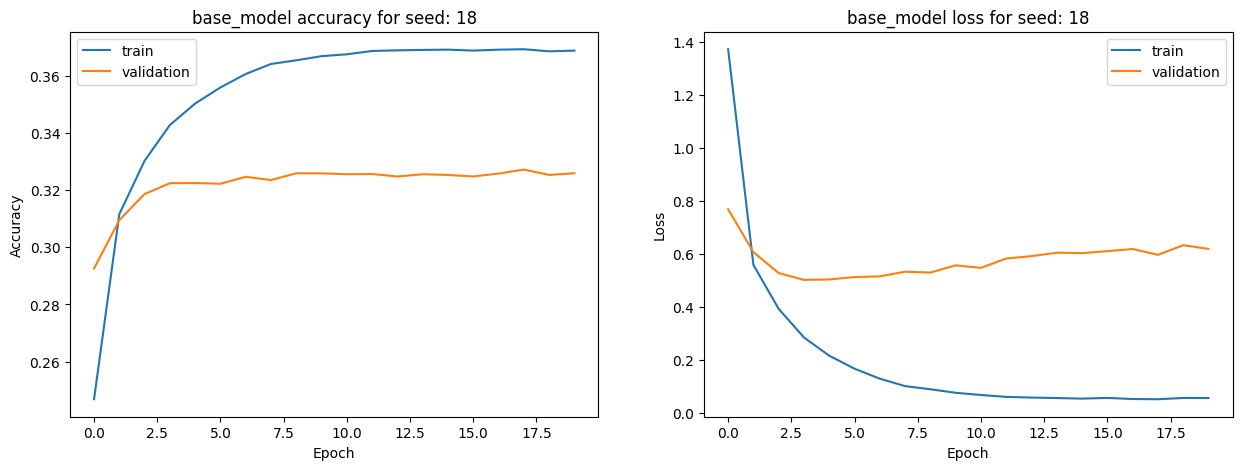

Scores for base_model with seed: 18
Loss: 0.5509951710700989
Accuracy: 0.3287770450115204
Macro F1: 0.8456159771227347


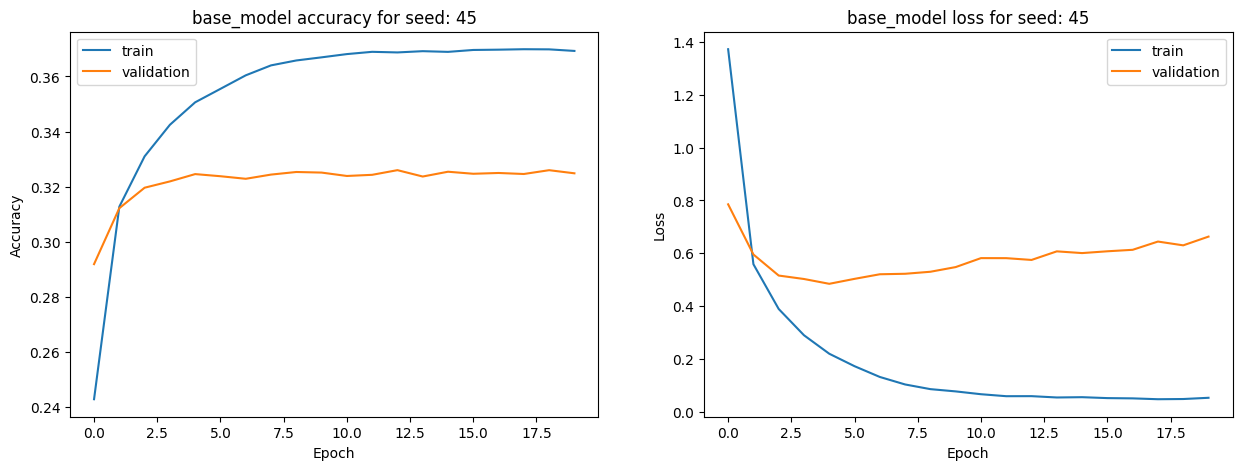

Scores for base_model with seed: 45
Loss: 0.5838401317596436
Accuracy: 0.32892194390296936
Macro F1: 0.8445805507007432


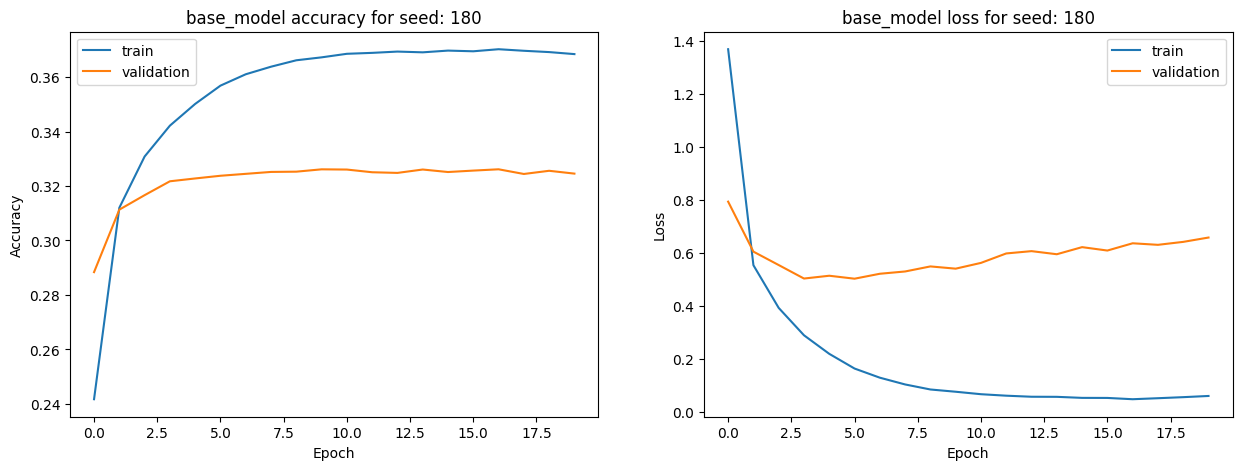

Scores for base_model with seed: 180
Loss: 0.596325159072876
Accuracy: 0.32773861289024353
Macro F1: 0.841476959062456


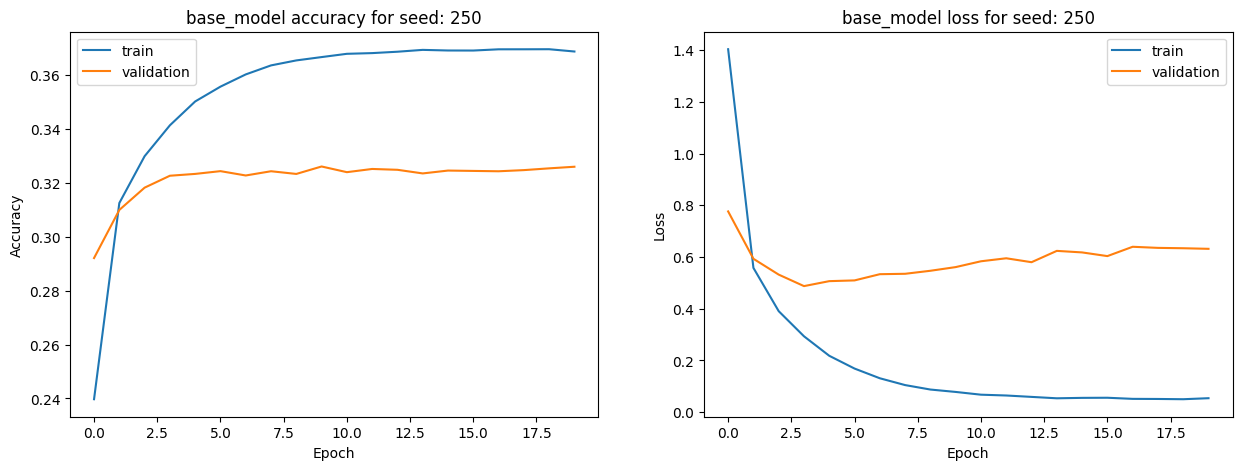

Scores for base_model with seed: 250
Loss: 0.5530627369880676
Accuracy: 0.3306849002838135
Macro F1: 0.8457824327040668


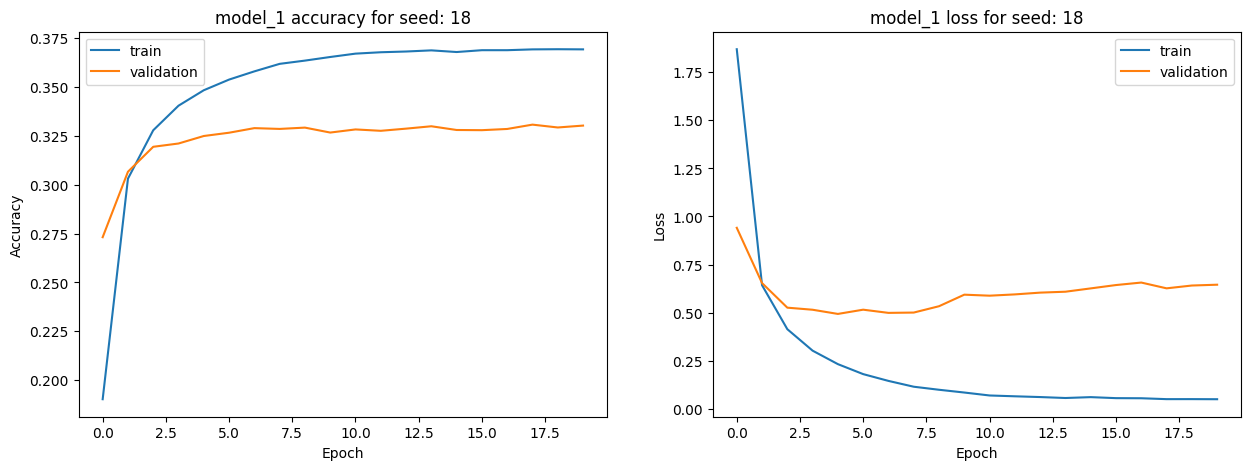

Scores for model_1 with seed: 18
Loss: 0.5713743567466736
Accuracy: 0.3342107832431793
Macro F1: 0.8603424267500446


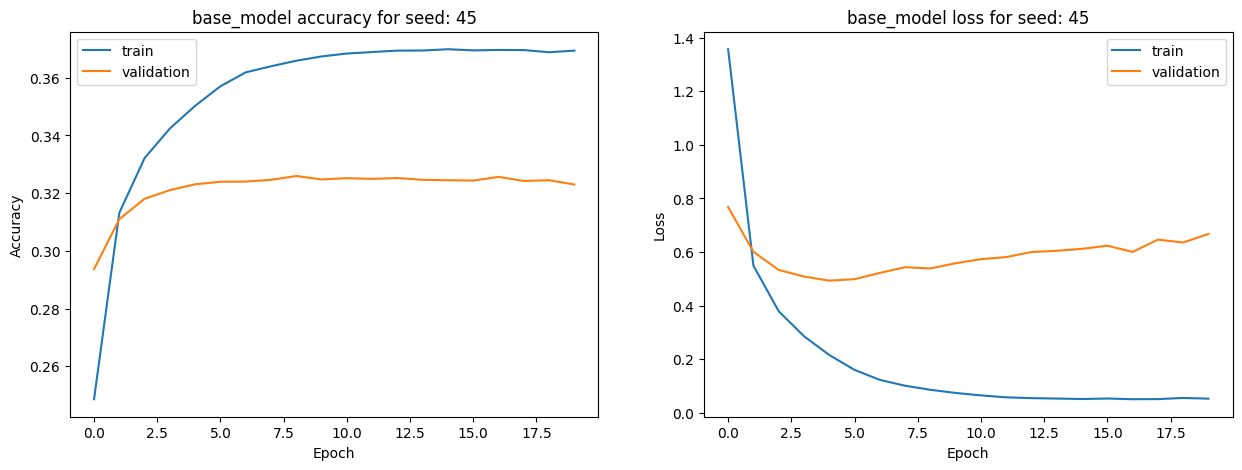

Scores for base_model with seed: 45
Loss: 0.6010345220565796
Accuracy: 0.32684504985809326
Macro F1: 0.839697672369737


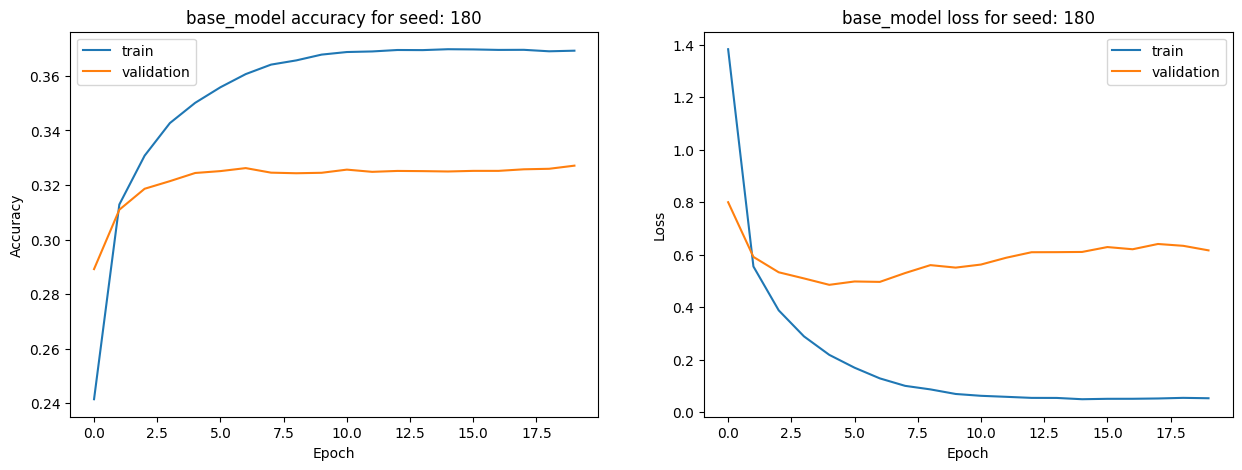

Scores for base_model with seed: 180
Loss: 0.5520583987236023
Accuracy: 0.33008113503456116
Macro F1: 0.8499503376802959


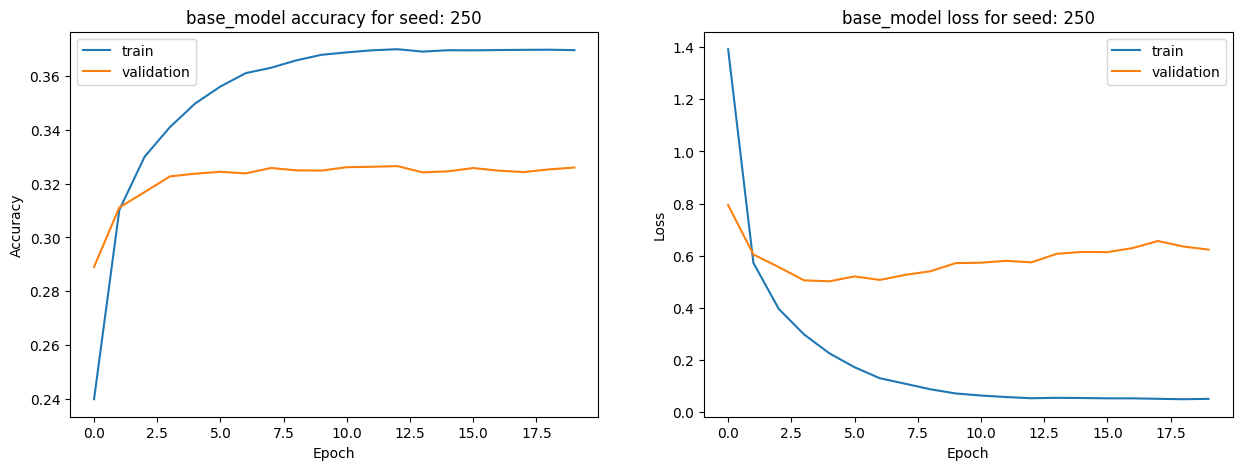

Scores for base_model with seed: 250
Loss: 0.5551023483276367
Accuracy: 0.328125
Macro F1: 0.846783979905599


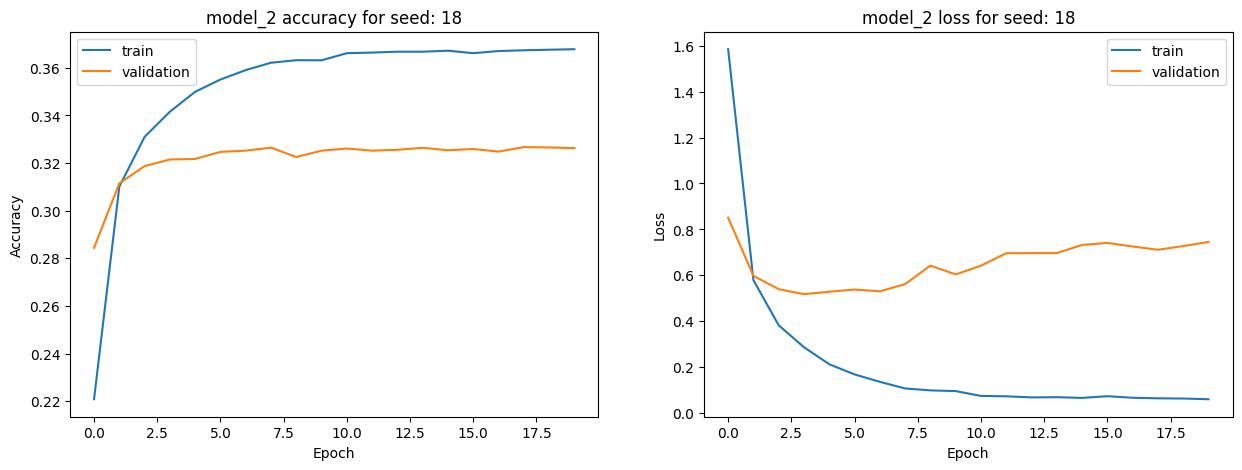

Scores for model_2 with seed: 18
Loss: 0.6772649884223938
Accuracy: 0.32868045568466187
Macro F1: 0.8496204703661462


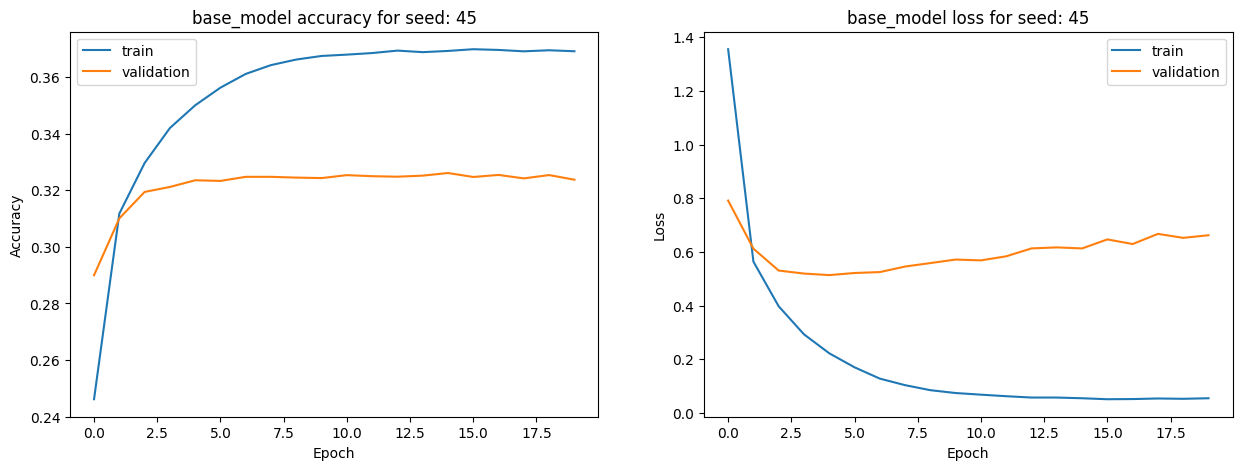

Scores for base_model with seed: 45
Loss: 0.607029914855957
Accuracy: 0.3263862133026123
Macro F1: 0.8411696946598476


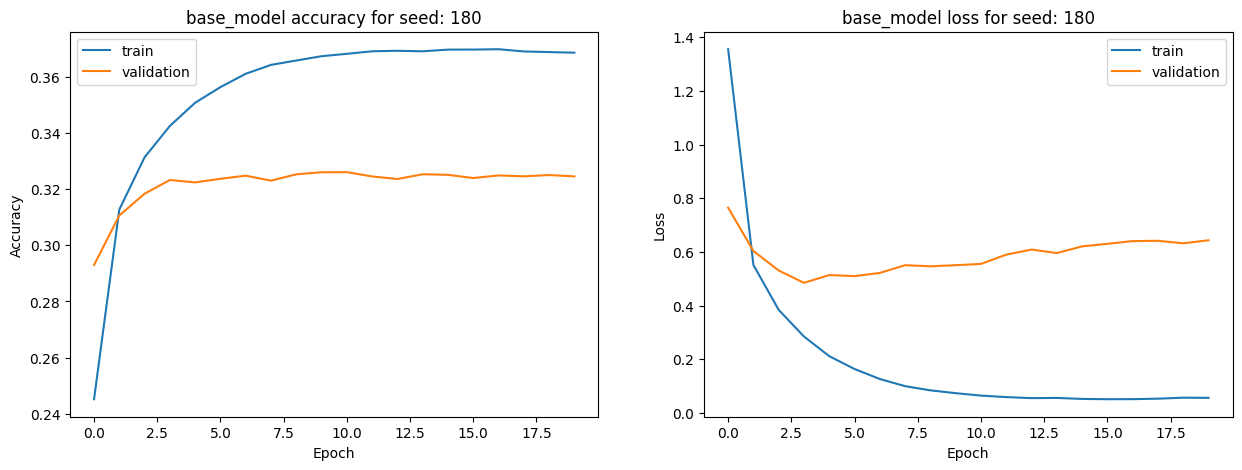

Scores for base_model with seed: 180
Loss: 0.58266681432724
Accuracy: 0.32940495014190674
Macro F1: 0.8410092330769129


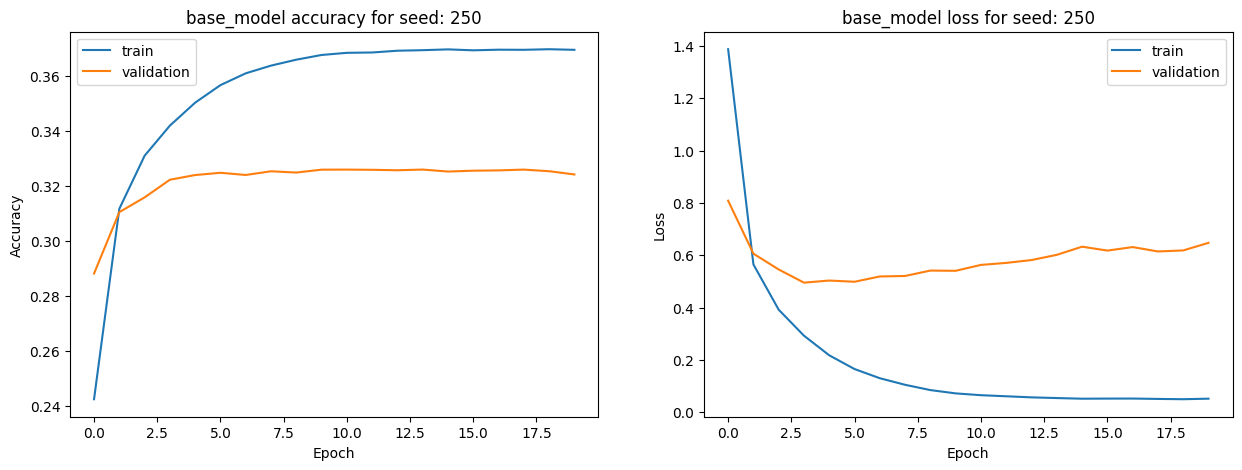

Scores for base_model with seed: 250
Loss: 0.5908339023590088
Accuracy: 0.32684504985809326
Macro F1: 0.8428705280738097


In [ ]:
#plot the results
def plot_results(model_recaps: List[Dict[str, any]]):
    for model_recap in model_recaps:
        model_name = model_recap['name']
        seed = model_recap['seed']
        history = model_recap['history']
        scores = model_recap['scores']
        macro_f1 = model_recap['macro_f1']

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title(f'{model_name} accuracy for seed: {seed}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title(f'{model_name} loss for seed: {seed}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

        print(f"Scores for {model_name} with seed: {seed}")
        print(f"Loss: {scores[0]}")
        print(f"Accuracy: {scores[1]}")
        print(f"Macro F1: {macro_f1}")

plot_results(baseline_recap)
plot_results(model_1_recap)
plot_results(model_2_recap)

From these graphs we can see that the models suffer for overfitting. In the future we can consider increasing model complexity and fine-tuning hyperparameters to enhance performance.

# Error analysis

In [ ]:
baseline_model = base_model_creator()
model_1 = mod_1_creator()
model_2 = mod_2_creator()

baseline_model.summary()
model_1.summary()
model_2.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 64, 50)         │       365,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 64, 512)        │       628,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64, 47)         │        24,111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,018,147 (3.88 MB)

 Trainable params: 652,847 (2.49 MB)

 Non-trainable params: 365,300 (1.39 MB)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 100, 50)        │       365,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 100, 512)       │       628,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 100, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100, 47)        │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,499 (6.34 MB)

 Trainable params: 1,297,199 (4.95 MB)

 Non-trainable params: 365,300 (1.39 MB)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 100, 50)        │       365,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 100, 512)       │       628,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 100, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100, 47)        │         3,055 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029,923 (3.93 MB)

 Trainable params: 664,623 (2.54 MB)

 Non-trainable params: 365,300 (1.39 MB)

"baseline_model.load_weights('base_model_seed_18.h5')\nmodel_1.load_weights('model_1_seed_18.h5')\nmodel_2.load_weights('model_2_seed_18.h5')"

In [ ]:
baseline_model.fit(X_train_pad, y_train_cat, validation_data=(X_val_pad, y_val_cat), epochs=20, batch_size=32)
model_1.fit(X_train_pad, y_train_cat, validation_data=(X_val_pad, y_val_cat), epochs=20, batch_size=32)
model_2.fit(X_train_pad, y_train_cat, validation_data=(X_val_pad, y_val_cat), epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.2107 - loss: 2.1047 - val_accuracy: 0.2910 - val_loss: 0.7778
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3118 - loss: 0.5865 - val_accuracy: 0.3124 - val_loss: 0.5902
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3342 - loss: 0.3836 - val_accuracy: 0.3172 - val_loss: 0.5415
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3432 - loss: 0.2879 - val_accuracy: 0.3222 - val_loss: 0.5036
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3585 - loss: 0.2020 - val_accuracy: 0.3244 - val_loss: 0.5014
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.3615 - loss: 0.1564 - val_accuracy: 0.3257 - val_loss: 0.5018
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3654 - loss: 0.1186 - val_accuracy: 0.3255 - val_loss: 0.5210
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.3755 - loss: 0.0931 - val_accuracy: 0

In [ ]:
def score_per_tag(y_true, y_pred):
    scores = {}
    '''first part of the function is the same as the macro_f1 function'''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    temp = []
    temp_pred = []
    for i in range(len(y_true)):
        if y_true[i] not in punct_pos__idx and y_true[i] != 0:
            temp.append(y_true[i])
            temp_pred.append(y_pred[i])

    '''second part of the function calculates the f1 score for each tag'''
    tag_true = []
    tag_pred = []
    for el in pos_to_idx.keys():
        tag_true = []
        tag_pred = []
        for i in range(len(temp)):
            if temp[i] == pos_to_idx.get(el) and pos_to_idx.get(el) not in punct_pos__idx:
                tag_true.append(temp[i])
                tag_pred.append(temp_pred[i])
        if len(tag_pred) != 0 and len(tag_true) != 0:
            scores[el] = f1_score(tag_true, tag_pred, average='macro')
    return scores

In [ ]:
def get_scores_tag(scores):
    # return a list of scores and a list of tags
    scores_tags =  {pos_to_idx[key]: value for key, value in scores.items()}
    scores_tags = {key: value for key, value in scores_tags.items() if value < 1.0}
    scores_tags =  {pos_to_idx[key]: value for key, value in scores_tags.items()}
    return scores_tags

In [ ]:
baseline_test_pred = baseline_model.predict(X_test_pad)
baseline_val_pred = baseline_model.predict(X_val_pad)
scores_baseline_test = score_per_tag(y_test_cat, baseline_test_pred)
print(scores_baseline_test)
scores_baseline_val = score_per_tag(y_test_cat, baseline_val_pred)
print(scores_baseline_val)

mod1_test_pred = model_1.predict(X_test_pad)
mod1_val_pred = model_1.predict(X_val_pad)
scores_mod1_test = score_per_tag(y_test_cat, baseline_test_pred)
print(scores_mod1_test)
scores_mod1_val = score_per_tag(y_test_cat, baseline_val_pred)
print(scores_mod1_val)

mod2_test_pred = model_2.predict(X_test_pad)
mod2_val_pred = model_2.predict(X_val_pad)
scores_mod2_test = score_per_tag(y_test_cat, baseline_test_pred)
print(scores_mod2_test)
scores_mod2_val = score_per_tag(y_test_cat, baseline_val_pred)
print(scores_mod2_val)



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
{'nn': 0.04386582219094534, 'nnp': 0.051918346208622845, 'in': 0.06928437416242295, 'dt': 0.11052937754508435, 'nns': 0.06127345959379553, 'jj': 0.04743137661619304, 'vbd': 0.05392569138673131, 'rb': 0.04651514007400136, 'cd': 0.09648181276088252, 'vb': 0.06868834490317867, 'cc': 0.24897400820793433, 'vbz': 0.08505509641873278, 'to': 1.0, 'vbn': 0.055780196993260756, 'prp': 0.49868766404199477, 'vbg': 0.04456521739130435, 'vbp': 0.06302521008403361, 'md': 0.33134920634920634, 'prp$': 1.0, 'pos': 1.0, "''": 1.0, 'wdt': 0.32741617357001973, 'jjr': 0.08421052631578947, 'wp': 1.0, 'rp': 0.2937853107344633, 'nnps': 0.03265306122448979, 'wrb': 0.22727272727272727, 'jjs': 0.16603773584905662, 'rbr': 0.34782608695652173, 'ex': 1.0, 'rbs': 0.25, 'pdt': 0.0, 'wp$': 1.0}
{'nn': 0.013818830589570999, 'nnp': 0.004646343093996524, 'in': 0.004653015695960481, 'dt': 0.004755408302475151, 'nns': 0.0026550238952150573, 'jj':

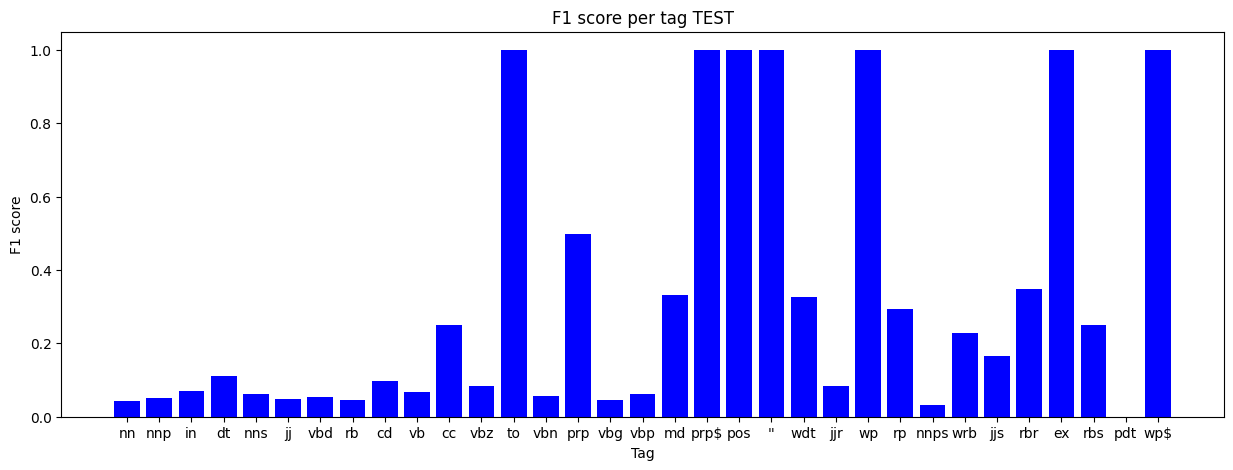

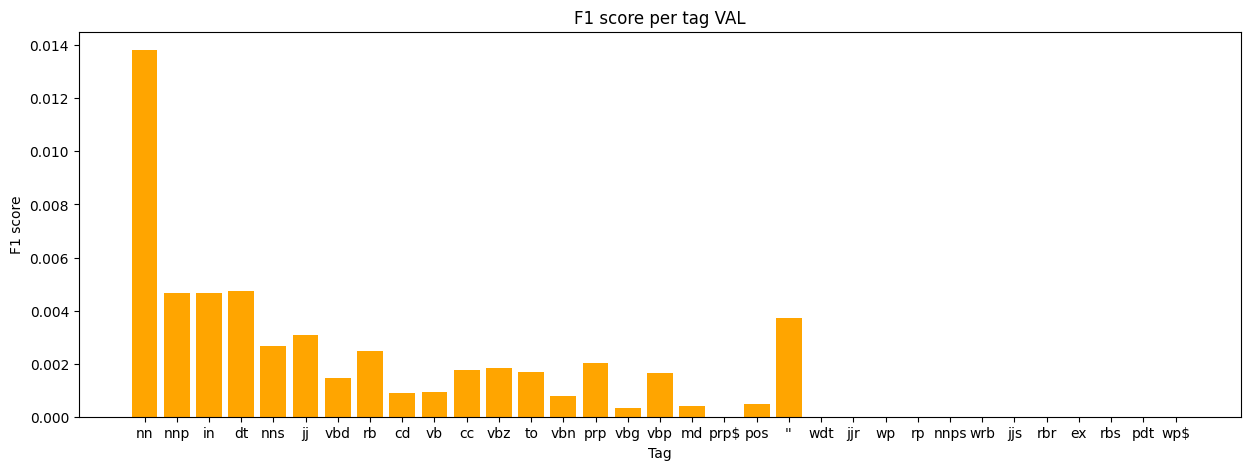

In [ ]:
#plot the scores
def plot_scores(scores, color, title):
    plt.figure(figsize=(15, 5))
    plt.bar(scores.keys(), scores.values(), color=color)
    plt.title(f"F1 score per tag {title}")
    plt.xlabel("Tag")
    plt.ylabel("F1 score")
    plt.show()

plot_scores(scores_baseline_test, 'Blue', 'TEST')
plot_scores(scores_baseline_val, 'Orange', 'VAL')

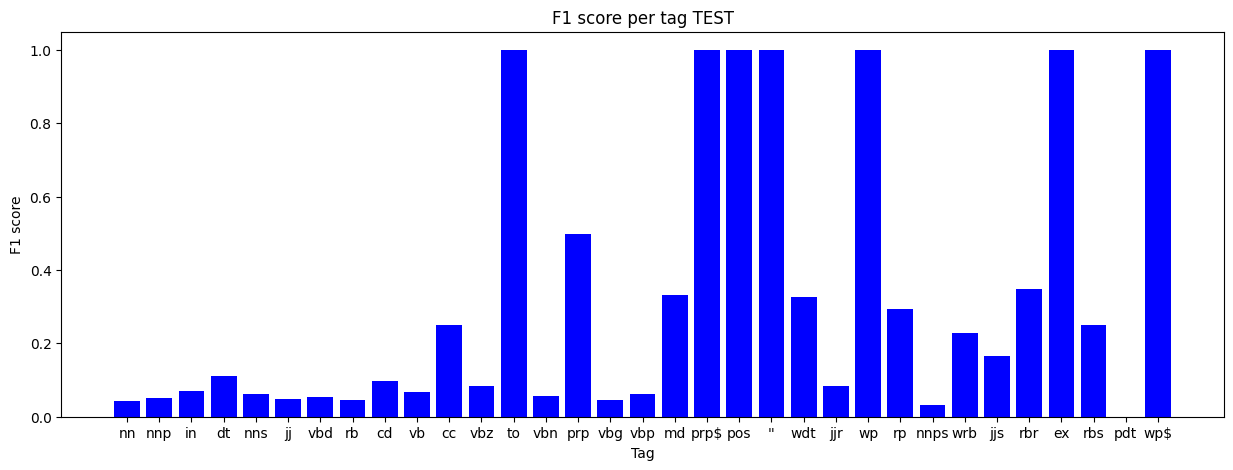

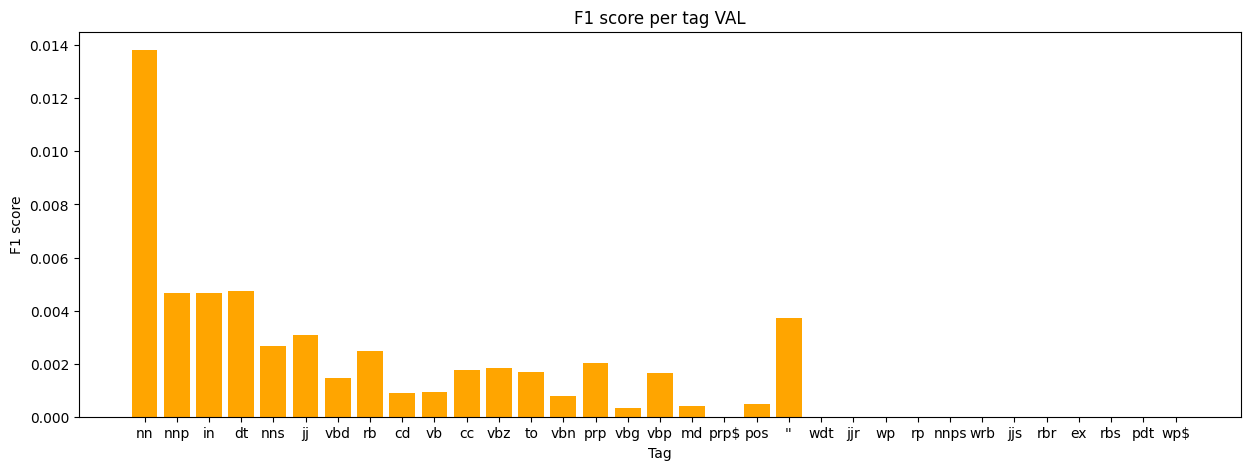

In [ ]:
plot_scores(scores_mod1_test, 'Blue', 'TEST')
plot_scores(scores_mod1_val, 'Orange', 'VAL')

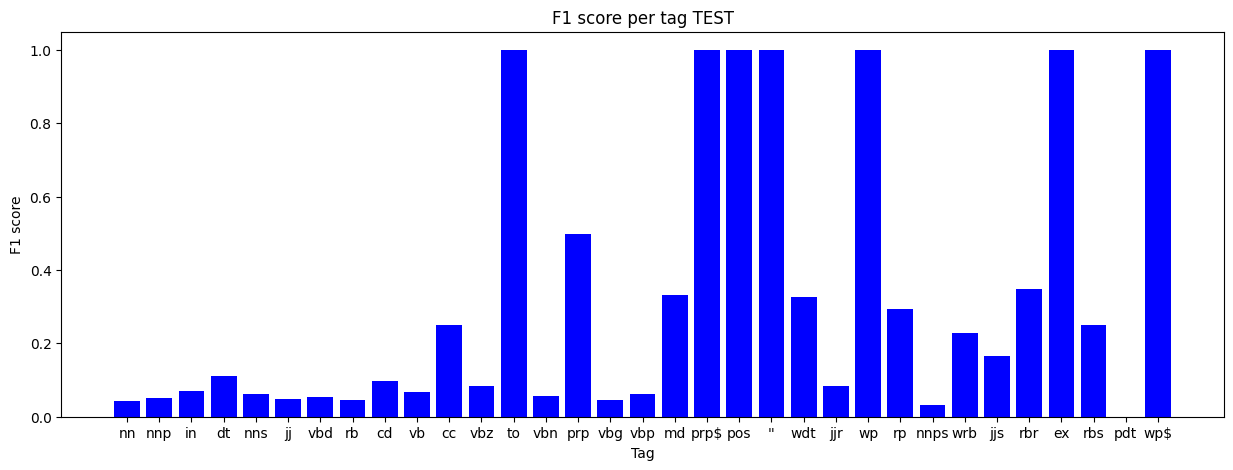

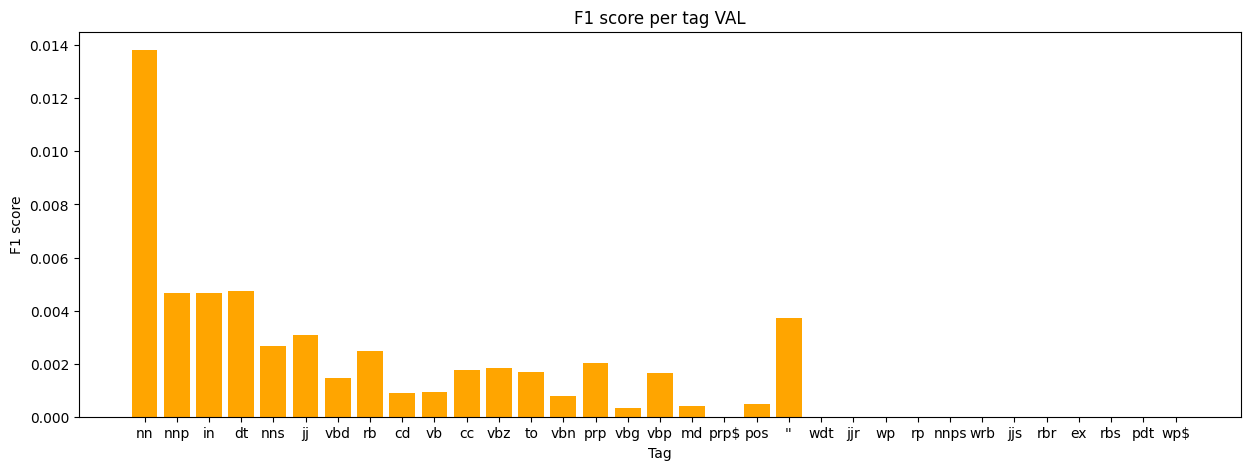

In [ ]:
plot_scores(scores_mod2_test, 'Blue', 'TEST')
plot_scores(scores_mod2_val, 'Orange', 'VAL')

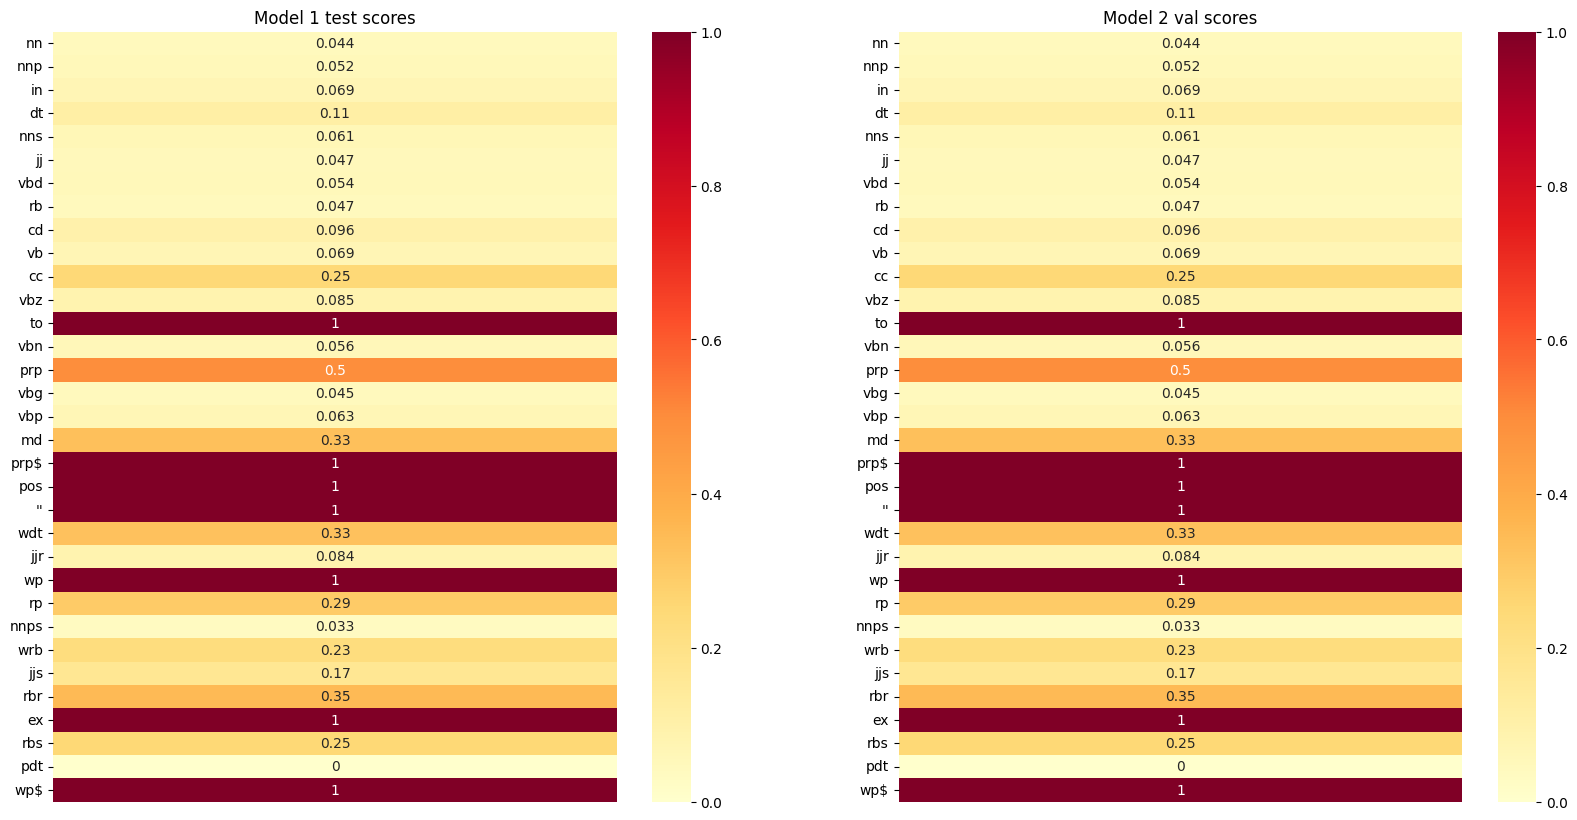

In [ ]:
# heatmap of the scores of model 1 on test set and validation set

# Test set
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.heatmap(pd.DataFrame(scores_mod1_test, index=[0]).T, annot=True, cmap='YlOrRd')
plt.title('Model 1 test scores')
# hide x labels
plt.xticks([])

# Validation set
plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(scores_mod2_test, index=[0]).T, annot=True, cmap='YlOrRd')
plt.title('Model 2 val scores')
# hide x labels
plt.xticks([])
plt.show()

We can see that the models' performance are very similar for the test set. We can expect that because also the F1-scores are similar. We can also see that the most common tags are the most difficult to evaluate.

In [ ]:
print("Most difficult tag for the baseline model on test set: {}".format(max(scores_baseline_test, key=scores_baseline_test.get)))
print("Most difficult tag for the baseline model on validation set: {}".format(max(scores_baseline_val, key=scores_baseline_val.get)))

print("Most difficult tag for the model 1 on test set: {}".format(max(scores_mod1_test, key=scores_baseline_test.get)))
print("Most difficult tag for the model 1 on validation set: {}".format(max(scores_mod1_val, key=scores_baseline_val.get)))

print("Most difficult tag for the model 2 on test set: {}".format(max(scores_mod2_test, key=scores_baseline_test.get)))
print("Most difficult tag for the model 2 on validation set: {}".format(max(scores_mod2_val, key=scores_baseline_val.get)))


Most difficult tag for the baseline model on test set: to
Most difficult tag for the baseline model on validation set: nn
Most difficult tag for the model 1 on test set: to
Most difficult tag for the model 1 on validation set: nn
Most difficult tag for the model 2 on test set: to
Most difficult tag for the model 2 on validation set: nn


We can see that the most difficult TAG is equal for each model, to solve this error one thing to do in the future could be to manage in a better way nouns during the pre-processing. For istance instead of random embedding matrix, we could use the neighbourhood strategy.

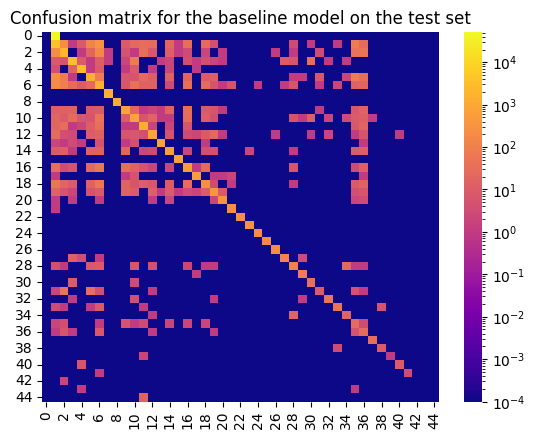

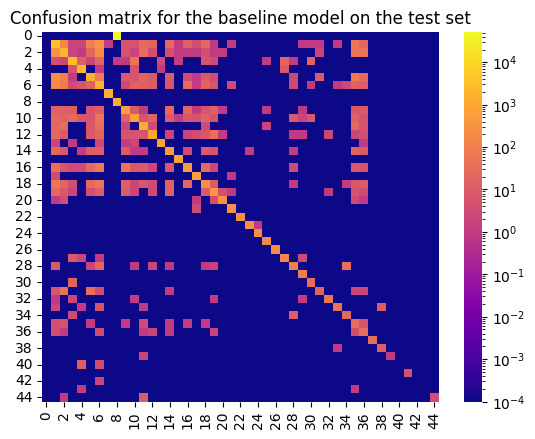

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
def get_confusion_matrix(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    temp = []
    temp_pred = []
    for i in range(len(y_true)):
        temp.append(y_true[i])
        temp_pred.append(y_pred[i])
    return confusion_matrix(temp, temp_pred)

baseline_confusion_matrix_test = get_confusion_matrix(y_val_cat, baseline_val_pred)
baseline_confusion_matrix_test = baseline_confusion_matrix_test + 0.0001


sns.heatmap(baseline_confusion_matrix_test, annot=False, cmap='plasma', norm=LogNorm())
plt.title('Confusion matrix for the baseline model on the test set')
plt.show()


mod1_confusion_matrix_test = get_confusion_matrix(y_val_cat, mod1_val_pred)
mod1_confusion_matrix_test = mod1_confusion_matrix_test + 0.0001

sns.heatmap(mod1_confusion_matrix_test, annot=False, cmap='plasma', norm=LogNorm())
plt.title('Confusion matrix for the model1 on the test set')

plt.show()


From the confusion matrix we can say that the model correctly predicts a large number of instances for most POS tags. while the clusters in the upper-left part indicate common misclassifications between specific POS tags. For instance, there might be confusion between tags that represent similar grammatical functions or have overlapping syntactic roles, such as adjectives and adverbs.

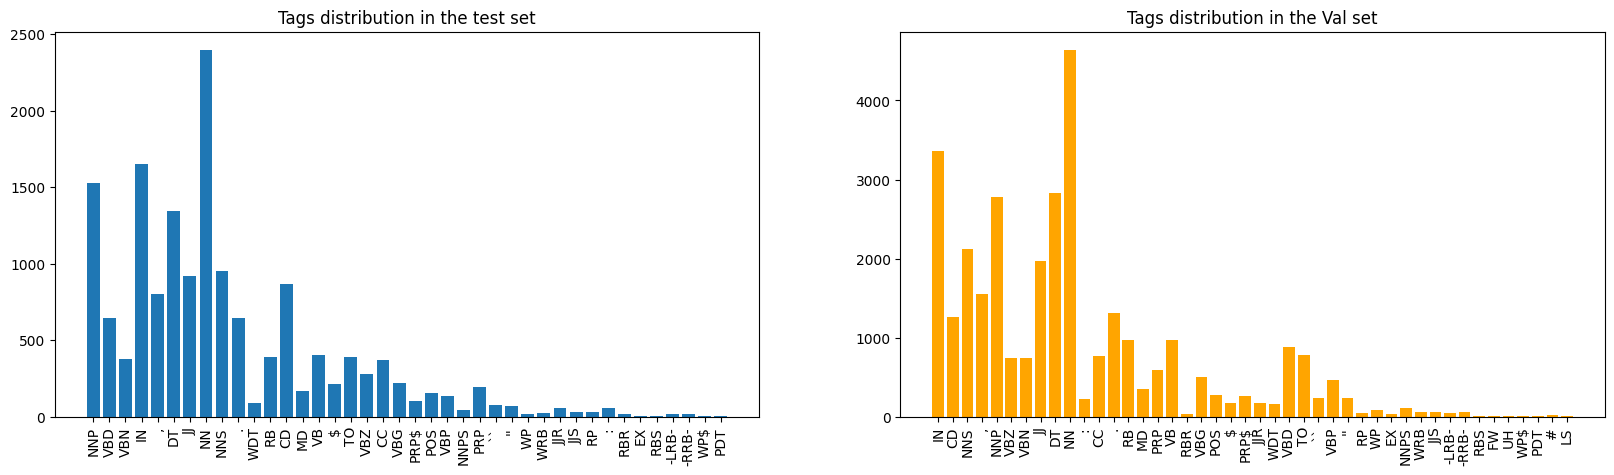

In [ ]:

from typing import Counter

def tag_counter(y_true):
    count_tags = Counter()
    for sentence in y_true:
        for tag in sentence:
            count_tags[tag] += 1

    return count_tags

count_test = tag_counter(y_test_raw)
count_val = tag_counter(y_val_raw)

# plot tags distribution in the test set
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.bar(count_test.keys(), count_test.values())
plt.title('Tags distribution in the test set')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.bar(count_val.keys(), count_val.values(), color = "Orange")
plt.title('Tags distribution in the Val set')
plt.xticks(rotation=90)

plt.show()



In [ ]:
def get_most_least_frequent_tag(encoded_tags):
    temp = []
    for sentence in encoded_tags:
        for tag in sentence:
            if tag not in punct_pos__idx and tag != 0:
                temp.append(tag)
    # get the most frequent tag
    most_frequent_tag = Counter(temp).most_common(1)[0][0]
    print(f'Times the most frequent tag appears: {Counter(temp).most_common(1)[0][1]}')
    # get the least frequent tag
    least_frequent_tag = Counter(temp).most_common()[-1][0]
    print(f'Times the least frequent tag appears: {Counter(temp).most_common()[-1][1]}')
    return most_frequent_tag, least_frequent_tag



Model 1 on test set:
Times the most frequent tag appears: 2396
Times the least frequent tag appears: 3
Most frequent tag: nn
Least frequent tag: rbs
Model 1 performance on the most frequent tag: 0.04386582219094534
Model 1 performance on the least frequent tag: 0.25
Model 2 on test set:
Model 1 performance on the most frequent tag: 0.04386582219094534
Model 1 performance on the least frequent tag: 0.25


NameError: name 'most_frequent_tag_val' is not defined

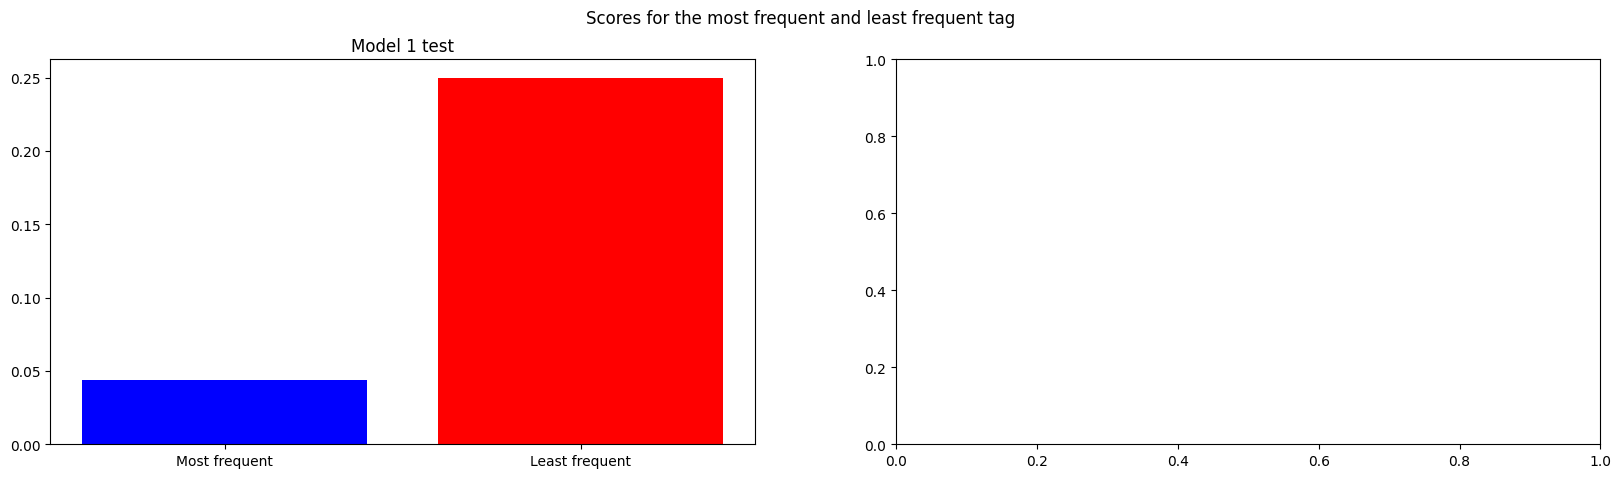

In [ ]:
most_frequent_tag_test, least_frequent_tag_test = get_most_least_frequent_tag(y_test)
print("Most frequent tag: {}".format(idx_to_pos[most_frequent_tag_test]))
print("Least frequent tag: {}".format(idx_to_pos[least_frequent_tag_test]))
print("Model 1 performance on the most frequent tag: {}".format(scores_mod1_test[idx_to_pos[most_frequent_tag_test]]))
print("Model 1 performance on the least frequent tag: {}".format(scores_mod1_test[idx_to_pos[least_frequent_tag_test]]))

#add model 2
print("Model 1 performance on the most frequent tag: {}".format(scores_mod2_test[idx_to_pos[most_frequent_tag_test]]))
print("Model 1 performance on the least frequent tag: {}".format(scores_mod2_test[idx_to_pos[least_frequent_tag_test]]))

Here are some example on missclassified samples, this is usefull to see what we can do to avoid this kind of missclassification. As we see the numbers can be handled in a better way, like giving them a specific token.

In [ ]:
# get specific missclassified samples for the model 1 and baseline model


y_pred = model_1.predict(X_test_pad)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred.flatten()
y_true = np.argmax(y_test_cat, axis=-1)
y_true = y_true.flatten()

temp = []
for i in range(len(X_test)):
    for elem in y_test[i]:
        temp.append(elem)
# get the index of the missclassified samples

missclassified_samples = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        if y_true[i] not in punct_pos__idx and y_true[i] != 0:
            missclassified_samples.append(i)

# create a table with the missclassified samples: word, true tag, predicted tag for the first 10 samples
sample_dict = {}
for i in range(10):
    sample_dict[i] = [train_tokenizer.sequences_to_texts([missclassified_samples[i:i+1]]), idx_to_pos[y_true[missclassified_samples[i]]], idx_to_pos[y_pred[missclassified_samples[i]]]]

# create a dataframe from the dictionary
df = pd.DataFrame.from_dict(sample_dict, orient='index', columns=['Word', 'True tag', 'Predicted tag'])
print(df)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
          Word True tag Predicted tag
0         [it]      nns           nnp
1         [on]      vbd           vbz
2     [market]      nnp         -rrb-
3         [we]       cd         -lrb-
4       [high]      nns            jj
5       [them]       cd            jj
6    [markets]      nnp         -rrb-
7       [1987]      nns            nn
8  [materials]      vbg            nn
9    [members]     nnps           nnp
